In [ ]:
import torch
from src.model.mae_vit import SSL_MAE, SSL_MAEViT, SSL_MAEPretrainDecoder

model = SSL_MAE(
    backbone=dict(
        type='SSL_MAEViT',
        # Явное задание параметров для ViT-Tiny
        arch=dict(
            embed_dims=192,
            num_layers=12,
            num_heads=3,
            feedforward_channels=192 * 4,  # Обычно 4x от embed_dim
        ),
        img_size=224,
        patch_size=16,
        mask_ratio=0.75,
        init_cfg=[
            dict(type='Xavier', layer='Linear', distribution='uniform'),
            dict(type='Constant', layer='LayerNorm', val=1.0, bias=0.0)
        ],
    ),
    neck=dict(
        type='SSL_MAEPretrainDecoder',
        embed_dim=192,        # Должно совпадать с embed_dims энкодера
        decoder_embed_dim=192,# Уменьшаем размер декодера для tiny модели
        decoder_depth=4,      # Можно уменьшить глубину (стандартно 8)
        decoder_num_heads=6,  # 192 / 32 = 6 голов (или 3)
        mlp_ratio=4,
        init_cfg=[
            dict(type='Xavier', layer='Linear', distribution='uniform'),
            dict(type='Constant', layer='LayerNorm', val=1.0, bias=0.0)
        ],
    ),
    head=dict(
        type='SSL_MAEPretrainHead',
        loss=dict(
            type='PixelReconstructionLoss',
            criterion='L1',
        ),
        init_cfg=[
            dict(type='Xavier', layer='Linear', distribution='uniform'),
            dict(type='Constant', layer='LayerNorm', val=1.0, bias=0.0)
        ],
        # norm_pix=True,  # Рекомендуется для MAE
    ),
 
)

model.backbone.init_weights()
model.neck.init_weights()
model.head.init_weights()




/Users/vladsanz/miniconda3/envs/ssl_project/lib/python3.11/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \
/Users/vladsanz/miniconda3/envs/ssl_project/lib/python3.11/site-packages/mmcv/cnn/bricks/transformer.py:33: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv`` rather than ``mmcv-lite`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '


12/14 00:46:21 - mmengine - INFO - 
cls_token - torch.Size([1, 1, 192]): 
The value is the same before and after calling `init_weights` of SSL_MAEViT  
 
12/14 00:46:21 - mmengine - INFO - 
pos_embed - torch.Size([1, 197, 192]): 
The value is the same before and after calling `init_weights` of SSL_MAEViT  
 
12/14 00:46:21 - mmengine - INFO - 
patch_embed.projection.weight - torch.Size([192, 3, 16, 16]): 
The value is the same before and after calling `init_weights` of SSL_MAEViT  
 
12/14 00:46:21 - mmengine - INFO - 
patch_embed.projection.bias - torch.Size([192]): 
The value is the same before and after calling `init_weights` of SSL_MAEViT  
 
12/14 00:46:21 - mmengine - INFO - 
layers.0.ln1.weight - torch.Size([192]): 
The value is the same before and after calling `init_weights` of SSL_MAEViT  
 
12/14 00:46:21 - mmengine - INFO - 
layers.0.ln1.bias - torch.Size([192]): 
The value is the same before and after calling `init_weights` of SSL_MAEViT  
 
12/14 00:46:21 - mmengine - INF

In [2]:
model.train()

SSL_MAE(
  (data_preprocessor): SelfSupDataPreprocessor()
  (backbone): SSL_MAEViT(
    (patch_embed): PatchEmbed(
      (adaptive_padding): AdaptivePadding()
      (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    )
    (drop_after_pos): Dropout(p=0, inplace=False)
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (ln1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): MultiheadAttention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0, inplace=False)
          (out_drop): DropPath()
          (gamma1): Identity()
        )
        (ln2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (ffn): FFN(
          (layers): Sequential(
            (0): Sequential(
              (0): Linear(in_features=192, out_features=768, bias=True)
              (1): GELU(approximate='none')
    

In [3]:
from PIL import Image
import torchvision.transforms as T

# Загружаем изображение
image_path = 'image.png'
image = Image.open(image_path).convert('RGB')

# Преобразование: изменение размера и конвертация в тензор
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

# Применяем трансформации и добавляем batch dimension
imgs = transform(image).unsqueeze(0).repeat(32, 1, 1, 1)

data = dict(inputs=imgs, data_samples=None)

# ВАЖНО: Модель возвращает features при обычном вызове model(inputs).
# Чтобы получить loss, нужно явно вызвать метод loss или передать mode='loss' (если поддерживается).
# Для SSL_MAE правильный способ получить loss вручную - вызвать метод loss.
losses = model.loss(inputs=imgs, data_samples=None)['loss'].mean()

    
print(f"Initial loss with real image: {losses.item()}")


Initial loss with real image: 0.8831841349601746


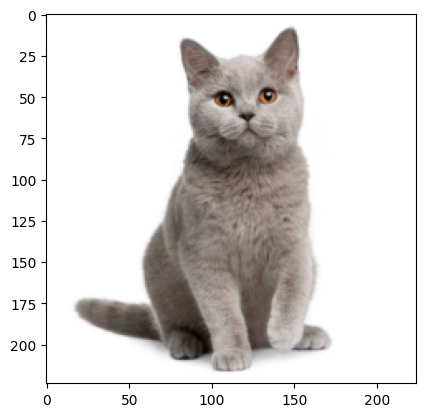

In [4]:
import matplotlib.pyplot as plt
img = imgs[0].permute(1, 2, 0)
plt.imshow(img)
plt.show()


In [5]:
# Дебаг training loop - обучение на одной картинке
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
# Настройки обучения
num_epochs = 400
warmup_epochs = 80
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Перемещаем модель и данные на устройство
model = model.to(device)
imgs = imgs.to(device)

# Создаем оптимизатор
initial_lr = 1.5e-4


optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=0.05, betas=(0.9, 0.95))

# Cosine decay scheduler с warmup
def get_lr(epoch):
    if epoch < warmup_epochs:
        # Linear warmup
        return initial_lr * (epoch + 1) / warmup_epochs
    else:
        # Cosine decay
        progress = (epoch - warmup_epochs) / (num_epochs - warmup_epochs)
        return initial_lr * 0.5 * (1 + math.cos(math.pi * progress))

# Списки для хранения истории обучения
train_losses = []

# Training loop
model.train()
for epoch in tqdm(range(num_epochs), desc="Training"):
    # Подготовка данных
    lr = get_lr(epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    data = dict(inputs=imgs, mode='loss')
    
    # Forward pass
    optimizer.zero_grad()
    outputs = model(**data)
    loss = outputs['loss'].mean()
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    # Сохраняем loss
    train_losses.append(loss.item())
    
    # Логируем каждые 5 эпох
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

print(f"\nTraining completed!")
print(f"Initial loss: {train_losses[0]:.6f}")
print(f"Final loss: {train_losses[-1]:.6f}")
print(f"Loss reduction: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.2f}%")

Using device: cpu


Training:   1%|▏         | 5/400 [00:01<02:19,  2.83it/s]

Epoch [5/400], Loss: 0.868391


Training:   2%|▎         | 10/400 [00:03<02:11,  2.96it/s]

Epoch [10/400], Loss: 0.829434


Training:   4%|▍         | 15/400 [00:05<02:13,  2.88it/s]

Epoch [15/400], Loss: 0.769173


Training:   5%|▌         | 20/400 [00:06<02:14,  2.83it/s]

Epoch [20/400], Loss: 0.717043


Training:   6%|▋         | 25/400 [00:09<02:27,  2.54it/s]

Epoch [25/400], Loss: 0.670977


Training:   8%|▊         | 30/400 [00:10<02:14,  2.75it/s]

Epoch [30/400], Loss: 0.628453


Training:   9%|▉         | 35/400 [00:12<02:12,  2.75it/s]

Epoch [35/400], Loss: 0.590000


Training:  10%|█         | 40/400 [00:14<02:06,  2.85it/s]

Epoch [40/400], Loss: 0.550027


Training:  11%|█▏        | 45/400 [00:16<02:02,  2.89it/s]

Epoch [45/400], Loss: 0.506567


Training:  12%|█▎        | 50/400 [00:17<02:05,  2.79it/s]

Epoch [50/400], Loss: 0.459782


Training:  14%|█▍        | 55/400 [00:19<02:08,  2.68it/s]

Epoch [55/400], Loss: 0.414899


Training:  15%|█▌        | 60/400 [00:21<01:57,  2.89it/s]

Epoch [60/400], Loss: 0.370452


Training:  16%|█▋        | 65/400 [00:23<01:54,  2.94it/s]

Epoch [65/400], Loss: 0.326188


Training:  18%|█▊        | 70/400 [00:24<01:54,  2.88it/s]

Epoch [70/400], Loss: 0.286013


Training:  19%|█▉        | 75/400 [00:26<01:41,  3.21it/s]

Epoch [75/400], Loss: 0.249639


Training:  20%|██        | 80/400 [00:28<01:46,  3.00it/s]

Epoch [80/400], Loss: 0.215009


Training:  21%|██▏       | 85/400 [00:29<01:42,  3.06it/s]

Epoch [85/400], Loss: 0.187867


Training:  22%|██▎       | 90/400 [00:31<01:36,  3.22it/s]

Epoch [90/400], Loss: 0.164112


Training:  24%|██▍       | 95/400 [00:32<01:25,  3.59it/s]

Epoch [95/400], Loss: 0.146954


Training:  25%|██▌       | 100/400 [00:34<01:26,  3.47it/s]

Epoch [100/400], Loss: 0.132108


Training:  26%|██▋       | 105/400 [00:35<01:24,  3.50it/s]

Epoch [105/400], Loss: 0.119634


Training:  28%|██▊       | 110/400 [00:37<01:35,  3.05it/s]

Epoch [110/400], Loss: 0.111067


Training:  29%|██▉       | 115/400 [00:38<01:29,  3.19it/s]

Epoch [115/400], Loss: 0.102580


Training:  30%|███       | 120/400 [00:40<01:28,  3.15it/s]

Epoch [120/400], Loss: 0.093568


Training:  31%|███▏      | 125/400 [00:42<01:25,  3.21it/s]

Epoch [125/400], Loss: 0.085750


Training:  32%|███▎      | 130/400 [00:43<01:18,  3.43it/s]

Epoch [130/400], Loss: 0.080734


Training:  34%|███▍      | 135/400 [00:44<01:14,  3.56it/s]

Epoch [135/400], Loss: 0.076631


Training:  35%|███▌      | 140/400 [00:46<01:15,  3.45it/s]

Epoch [140/400], Loss: 0.072011


Training:  36%|███▋      | 145/400 [00:47<01:13,  3.47it/s]

Epoch [145/400], Loss: 0.069335


Training:  38%|███▊      | 150/400 [00:49<01:14,  3.37it/s]

Epoch [150/400], Loss: 0.066434


Training:  39%|███▉      | 155/400 [00:50<01:11,  3.44it/s]

Epoch [155/400], Loss: 0.065982


Training:  40%|████      | 160/400 [00:52<01:08,  3.52it/s]

Epoch [160/400], Loss: 0.063259


Training:  41%|████▏     | 165/400 [00:53<01:08,  3.43it/s]

Epoch [165/400], Loss: 0.062226


Training:  42%|████▎     | 170/400 [00:55<01:05,  3.53it/s]

Epoch [170/400], Loss: 0.061021


Training:  44%|████▍     | 175/400 [00:56<01:04,  3.48it/s]

Epoch [175/400], Loss: 0.058862


Training:  45%|████▌     | 180/400 [00:57<01:02,  3.53it/s]

Epoch [180/400], Loss: 0.057928


Training:  46%|████▋     | 185/400 [00:59<01:02,  3.44it/s]

Epoch [185/400], Loss: 0.057763


Training:  48%|████▊     | 190/400 [01:00<01:02,  3.37it/s]

Epoch [190/400], Loss: 0.056012


Training:  49%|████▉     | 195/400 [01:02<00:59,  3.44it/s]

Epoch [195/400], Loss: 0.056369


Training:  50%|█████     | 200/400 [01:03<01:04,  3.10it/s]

Epoch [200/400], Loss: 0.056513


Training:  51%|█████▏    | 205/400 [01:05<01:03,  3.07it/s]

Epoch [205/400], Loss: 0.054795


Training:  52%|█████▎    | 210/400 [01:07<01:05,  2.91it/s]

Epoch [210/400], Loss: 0.055207


Training:  54%|█████▍    | 215/400 [01:08<01:03,  2.91it/s]

Epoch [215/400], Loss: 0.053700


Training:  55%|█████▌    | 220/400 [01:10<00:55,  3.26it/s]

Epoch [220/400], Loss: 0.053325


Training:  56%|█████▋    | 225/400 [01:11<00:49,  3.55it/s]

Epoch [225/400], Loss: 0.052016


Training:  57%|█████▊    | 230/400 [01:13<00:49,  3.41it/s]

Epoch [230/400], Loss: 0.052389


Training:  59%|█████▉    | 235/400 [01:14<00:47,  3.51it/s]

Epoch [235/400], Loss: 0.053095


Training:  60%|██████    | 240/400 [01:16<00:45,  3.51it/s]

Epoch [240/400], Loss: 0.051273


Training:  61%|██████▏   | 245/400 [01:17<00:46,  3.36it/s]

Epoch [245/400], Loss: 0.050430


Training:  62%|██████▎   | 250/400 [01:19<00:44,  3.35it/s]

Epoch [250/400], Loss: 0.050961


Training:  64%|██████▍   | 255/400 [01:20<00:42,  3.37it/s]

Epoch [255/400], Loss: 0.050669


Training:  65%|██████▌   | 260/400 [01:22<00:40,  3.45it/s]

Epoch [260/400], Loss: 0.050252


Training:  66%|██████▋   | 265/400 [01:23<00:39,  3.46it/s]

Epoch [265/400], Loss: 0.049803


Training:  68%|██████▊   | 270/400 [01:25<00:37,  3.49it/s]

Epoch [270/400], Loss: 0.049425


Training:  69%|██████▉   | 275/400 [01:26<00:35,  3.51it/s]

Epoch [275/400], Loss: 0.050375


Training:  70%|███████   | 280/400 [01:27<00:35,  3.35it/s]

Epoch [280/400], Loss: 0.049111


Training:  71%|███████▏  | 285/400 [01:29<00:38,  3.01it/s]

Epoch [285/400], Loss: 0.049781


Training:  72%|███████▎  | 290/400 [01:31<00:35,  3.06it/s]

Epoch [290/400], Loss: 0.049025


Training:  74%|███████▍  | 295/400 [01:32<00:34,  3.06it/s]

Epoch [295/400], Loss: 0.048912


Training:  75%|███████▌  | 300/400 [01:34<00:31,  3.16it/s]

Epoch [300/400], Loss: 0.049173


Training:  76%|███████▋  | 305/400 [01:35<00:28,  3.31it/s]

Epoch [305/400], Loss: 0.048344


Training:  78%|███████▊  | 310/400 [01:37<00:27,  3.23it/s]

Epoch [310/400], Loss: 0.048940


Training:  79%|███████▉  | 315/400 [01:38<00:25,  3.31it/s]

Epoch [315/400], Loss: 0.048514


Training:  80%|████████  | 320/400 [01:40<00:24,  3.28it/s]

Epoch [320/400], Loss: 0.048415


Training:  81%|████████▏ | 325/400 [01:42<00:23,  3.24it/s]

Epoch [325/400], Loss: 0.048870


Training:  82%|████████▎ | 330/400 [01:43<00:21,  3.26it/s]

Epoch [330/400], Loss: 0.048247


Training:  84%|████████▍ | 335/400 [01:45<00:20,  3.16it/s]

Epoch [335/400], Loss: 0.047768


Training:  85%|████████▌ | 340/400 [01:46<00:18,  3.28it/s]

Epoch [340/400], Loss: 0.047999


Training:  86%|████████▋ | 345/400 [01:48<00:16,  3.33it/s]

Epoch [345/400], Loss: 0.047973


Training:  88%|████████▊ | 350/400 [01:49<00:15,  3.16it/s]

Epoch [350/400], Loss: 0.047838


Training:  89%|████████▉ | 355/400 [01:51<00:14,  3.16it/s]

Epoch [355/400], Loss: 0.047637


Training:  90%|█████████ | 360/400 [01:52<00:11,  3.36it/s]

Epoch [360/400], Loss: 0.047464


Training:  91%|█████████▏| 365/400 [01:54<00:10,  3.25it/s]

Epoch [365/400], Loss: 0.048272


Training:  92%|█████████▎| 370/400 [01:55<00:09,  3.12it/s]

Epoch [370/400], Loss: 0.048239


Training:  94%|█████████▍| 375/400 [01:57<00:07,  3.28it/s]

Epoch [375/400], Loss: 0.048107


Training:  95%|█████████▌| 380/400 [01:59<00:06,  3.33it/s]

Epoch [380/400], Loss: 0.047481


Training:  96%|█████████▋| 385/400 [02:00<00:04,  3.24it/s]

Epoch [385/400], Loss: 0.047076


Training:  98%|█████████▊| 390/400 [02:02<00:03,  3.32it/s]

Epoch [390/400], Loss: 0.048117


Training:  99%|█████████▉| 395/400 [02:03<00:01,  3.35it/s]

Epoch [395/400], Loss: 0.047890


Training: 100%|██████████| 400/400 [02:05<00:00,  3.19it/s]

Epoch [400/400], Loss: 0.047633

Training completed!
Initial loss: 0.883999
Final loss: 0.047633
Loss reduction: 94.61%


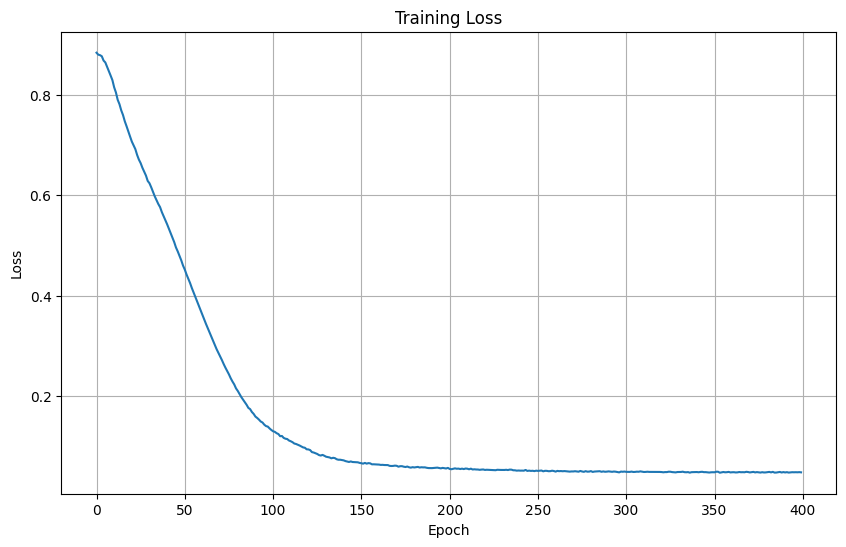

In [6]:
# Визуализация кривой обучения
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()


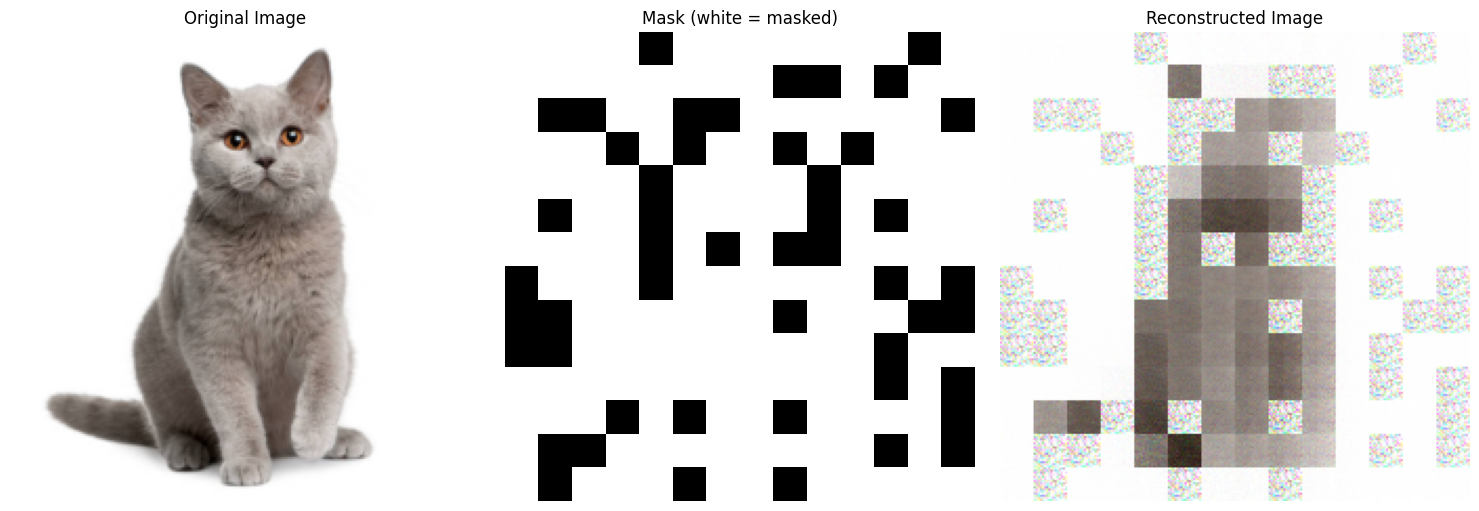

In [7]:
# Визуализация реконструкции
model.eval()
with torch.no_grad():
    # Получаем реконструкцию из модели
    # Вызываем backbone и neck напрямую для получения предсказаний
    latent, mask, ids_restore = model.backbone(imgs)
    pred = model.neck(latent, ids_restore)
    
    # Преобразуем предсказания обратно в изображение
    # pred имеет форму (B, num_patches, patch_size^2 * channels)
    reconstructed = model.head.unpatchify(pred)
    
    # Нормализуем для визуализации (приводим к диапазону [0, 1])
    # Если значения уже в [0, 1], просто ограничиваем
    reconstructed = torch.clamp(reconstructed, 0, 1)

# Визуализация с маской
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Оригинальное изображение
orig_img = imgs[0].cpu().permute(1, 2, 0).detach()
axes[0].imshow(orig_img)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Маска (показываем, какие патчи были замаскированы)
# mask имеет форму (B, L), где L - количество патчей
mask_img = mask[0].cpu().detach().numpy()
# Преобразуем 1D маску в 2D изображение
h = w = int(mask_img.shape[0] ** 0.5)
mask_img = mask_img.reshape(h, w)
# Масштабируем маску до размера изображения для наглядности (опционально, imshow сделает это сам)
axes[1].imshow(mask_img, cmap='gray', interpolation='nearest')
axes[1].set_title('Mask (white = masked)')
axes[1].axis('off')

# Реконструированное изображение
recon_img = reconstructed[0].cpu().permute(1, 2, 0).detach()
axes[2].imshow(recon_img)
axes[2].set_title('Reconstructed Image')
axes[2].axis('off')

plt.tight_layout()
plt.show()